# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 81.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.19
    Uninstalling botocore-1.24.19:
      Successfully uninstalled botocore-1.24.19
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.25.42 requires botocore==1.27.42, but you have botocore 1.27.47 which is incompatible.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.27.47 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip



In [3]:
sagemaker_session = sagemaker.Session()

In [4]:
bucket = 'sagemaker-us-east-1-337308426927'
prefix = "data/dogImages"

In [10]:
bucket

'sagemaker-us-east-1-337308426927'

bucket = sagemaker_session.default_bucket()
prefix = "data/dogImages"

inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
#TODO: Declare your HP ranges, metrics etc.

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [6]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=sagemaker.get_execution_role(),
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)


In [6]:
training_path= "s3://{}/{}/".format(bucket, "data/dogImages")
s3_output_dir = "s3://{}/{}/".format(bucket, "output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")
os.environ['SM_CHANNEL_TRAIN']=training_path
os.environ['SM_MODEL_DIR']=s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']=s3_output_dir

In [13]:
s3_model_dir

's3://sagemaker-us-east-1-337308426927/model/'

In [8]:
# TODO: Fit your HP Tuner
tuner.fit({'train': training_path}, wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..............................................................................................................................................................................................................................................................................................!


In [9]:
best_estimator = tuner.best_estimator()


2022-08-09 11:17:01 Starting - Preparing the instances for training
2022-08-09 11:17:01 Downloading - Downloading input data
2022-08-09 11:17:01 Training - Training image download completed. Training in progress.
2022-08-09 11:17:01 Uploading - Uploading generated training model
2022-08-09 11:17:01 Completed - Training job completed


In [10]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-08-09 11:17:01 Starting - Preparing the instances for training
2022-08-09 11:17:01 Downloading - Downloading input data
2022-08-09 11:17:01 Training - Training image download completed. Training in progress.
2022-08-09 11:17:01 Uploading - Uploading generated training model
2022-08-09 11:17:01 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'lr': '0.0010890341083269243',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-08-09-10-54-28-261"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-337308426927/pytorch-training-2022-08-09-10-54-28-261/source/sourcedir.tar.gz"'}

In [13]:
best_estimator.hyperparameters()['batch-size']

'"256"'

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [8]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
import sagemaker
from sagemaker.pytorch import PyTorch
import boto3
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts


rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

[2022-08-09 13:51:46.095 ip-172-16-182-17.ec2.internal:25642 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [9]:
# TODO: Create and fit an estimator

hyperparameters = {"lr": '0.0010890341083269243',
                  "batch-size": 256}

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    profiler_config=profiler_config,
    hyperparameters=hyperparameters,
    debugger_hook_config=debugger_config,
    rules=rules,
)

#os.environ['SM_CHANNEL_TRAIN']=training_path
#os.environ['SM_MODEL_DIR']=s3_model_dir
#os.environ['SM_OUTPUT_DATA_DIR']=s3_output_dir
estimator.fit({"train": training_path}, wait=True)

2022-08-09 13:51:49 Starting - Starting the training job...
2022-08-09 13:52:15 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-08-09 13:53:37 Downloading - Downloading input data.........
2022-08-09 13:55:18 Training - Downloading the training image..................
2022-08-09 13:58:19 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-08-09 13:58:17,691 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-08-09 13:58:17,718 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-08-09 13:58:17,726 sagemaker_pytorch_container.training INFO     Invoking user traini

In [13]:
training_job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [14]:
# TODO: Plot a debutraining_job_name = estimator.latest_training_job.name
session = boto3.session.Session()
region = session.region_name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("NLLLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("NLLLoss_output_0").steps(mode=ModeKeys.EVAL)))



Training jobname: pytorch-training-2022-08-09-13-51-48-889
Region: us-east-1
[2022-08-09 14:16:07.068 ip-172-16-182-17.ec2.internal:25642 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-337308426927/pytorch-training-2022-08-09-13-51-48-889/debug-output
[2022-08-09 14:16:07.528 ip-172-16-182-17.ec2.internal:25642 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2022-08-09 14:16:08.552 ip-172-16-182-17.ec2.internal:25642 INFO trial.py:210] Loaded all steps
['NLLLoss_output_0', 'gradient/ResNet_bn1.bias', 'gradient/ResNet_bn1.weight', 'gradient/ResNet_conv1.weight', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_layer1.0.bn1.bias', 'gradient/ResNet_layer1.0.bn1.weight', 'gradient/ResNet_layer1.0.bn2.bias', 'gradient/ResNet_layer1.0.bn2.weight', 'gradient/ResNet_layer1.0.conv1.weight', 'gradient/ResNet_layer1.0.conv2.weight', 'gradient/ResNet_layer1.1.bn1.bias', 'gradient/ResNet_layer1.1.bn1.weight'

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [16]:
# TODO: Display the profiler output

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")


ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-337308426927/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-337308426927/pytorch-training-2022-08-09-13-51-48-889/profiler-output


Profiler data from system is available
[2022-08-09 14:18:06.983 ip-172-16-182-17.ec2.internal:25642 INFO metrics_reader_base.py:134] Getting 12 event files
select events:['total']
select dimen

You will find the profiler report in s3://sagemaker-us-east-1-337308426927/pytorch-training-2022-08-09-13-51-48-889/rule-output


## Model Deploying

In [17]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium") # TODO: Add your deployment configuration like instance type and number of instances

---------!

In [8]:
predictor = sagemaker.predictor.Predictor('pytorch-training-2022-08-09-14-18-19-119', sagemaker_session=sagemaker_session)

In [25]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 38.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 845.6 kB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [26]:
import torchvision
import torchvision.transforms as transforms

In [24]:
from sagemaker.pytorch import PyTorch
import sagemaker

In [ ]:
s3://sagemaker-us-east-1-337308426927/data/dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg

In [12]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 68.5 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [27]:
import io

In [41]:
#buf = io.BytesIO()
image = Image.open(train_image_path)


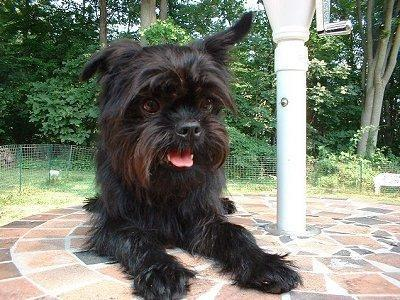

In [42]:
image

In [43]:
payload = testing_transform(image)

In [45]:
np.array(payload)

array([[[-0.40392154, -0.7019608 , -0.30196077, ..., -0.60784316,
         -0.7490196 , -0.60784316],
        [-0.23921567, -0.49019605, -0.6156863 , ..., -0.75686276,
         -0.77254903, -0.54509807],
        [-0.35686272, -0.17647058, -0.49019605, ..., -0.7882353 ,
         -0.6862745 , -0.4980392 ],
        ...,
        [ 0.79607844,  0.75686276,  0.70980394, ...,  0.8352941 ,
          0.7882353 ,  0.7490196 ],
        [ 0.8509804 ,  0.8039216 ,  0.7176471 , ...,  0.6784314 ,
          0.7490196 ,  0.73333335],
        [ 0.84313726,  0.8039216 ,  0.7411765 , ...,  0.5372549 ,
          0.6784314 ,  0.6784314 ]],

       [[-0.31764704, -0.60784316, -0.19215685, ..., -0.5294118 ,
         -0.7254902 , -0.6156863 ],
        [-0.14509803, -0.38039213, -0.4980392 , ..., -0.6784314 ,
         -0.7411765 , -0.5529412 ],
        [-0.24705881, -0.05098039, -0.34117645, ..., -0.7019608 ,
         -0.654902  , -0.5058824 ],
        ...,
        [ 0.45882356,  0.43529415,  0.41176474, ...,  

In [48]:

response = predictor.predict(data = np.ndarray.tobytes(np.array(payload)))

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-training-2022-08-09-14-18-19-119 in account 337308426927 for more information.

In [25]:
from PIL import Image

import torch.nn as nn

from torchvision import datasets
import numpy as np
import torchvision.transforms as transforms
train_image_path = "Affenpinscher_00001.jpg"

import json

image = Image.open(train_image_path)
batch_size = 1
image = np.asarray(image.resize((224, 224)))
#image = image / 128 - 1
#image = np.concatenate([image[np.newaxis, :, :]] * batch_size)
body = json.dumps({"instances": image.tolist()})

#data=np.reshape(data[b'data'][0], (3, 32, 32))
#payload = training_transform(payload)
response = predictor.predict(data = body)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-training-2022-08-09-14-18-19-119 in account 337308426927 for more information.

In [32]:
train_image_path = "s3://sagemaker-us-east-1-337308426927/data/dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg"

training_transform = transforms.Compose([
transforms.RandomHorizontalFlip(),
transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#testing_transform = transforms.Compose([transforms.Resize((224,224)),
#                                        transforms.ToTensor(),
#transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                                       ])
torchvision.datasets.ImageFolder(root=train_image_path,transform=training_transform),

FileNotFoundError: [Errno 2] No such file or directory: 's3://sagemaker-us-east-1-337308426927/data/dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'

In [21]:
import io
import requests
from PIL import Image


path = "s3://sagemaker-us-east-1-337308426927/data/dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg"
response = requests.get(path)
#img_pil = Image.open(io.BytesIO(response.content))

InvalidSchema: No connection adapters were found for 's3://sagemaker-us-east-1-337308426927/data/dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'

In [ ]:
# TODO: Run an prediction on the endpoint
path = "/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg"

import io

import requests
import torchvision.transforms as T

from PIL import Image

resp = requests.get('https://sparrow.dev/assets/img/cat.jpg')
img = Image.open(io.BytesIO(resp.content))

preprocess = T.Compose([
   T.Resize(256),
   T.CenterCrop(224),
   T.ToTensor(),
   T.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

x = preprocess(img)

data=np.reshape(data[b'data'][0], (3, 32, 32))


image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [39]:
response = predictor.predict(x)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-training-2022-08-09-14-18-19-119 in account 337308426927 for more information.

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()